In [380]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual
import plotly.graph_objects as go
import folium
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from tqdm.notebook import trange, tqdm

# Supress scientific notation/warning
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

## Load Data

In [381]:
# World Confirmed Cases
confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
# World Death Cases
death_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

### DataFrame Cleaning

In [382]:
# Get a list of columns, this serves to know which ones to clean
list(confirmed_df.columns)[0:5]

['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20']

In [383]:
# Get a list of columns, this serves to know which ones to clean
list(death_df.columns)[0:5]

['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20']

In [384]:
confirmed_df.sample(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
164,NaN,Libya,26.33510,17.22833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,8,8,10,10,11,11,18,18,19,20,21,24,24,24,25,26,35,48,49,49,49,51,51,51,59,60,61,61,61,61,61,61,61,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,65,65,65,68,69,71,72,75,75,75,77,99,105,118,130,156,168,182,196,209,239,256,256,332,359,378,393,409,418,454,467,484,500,510,520,544,571,595,639,670,698,713,727,762,802,824,874,891,918,989,1046,1117,1182,1268,1342,1342,1389,1433,1512,1563,1589,1652,1704,1791,1866,1980,2088,2176,2314,2424,2547,2669,2827,3017,3222,3438,3621,3691,3837,4063,4224,4475,4879,5079,5232,5451,5929,6302,6611,7050,7327,7738,8172,8579,9068,9463,9707,10121,10437,10437,11009,11281,11834,12274,12629,12958,13423,13966,14624,15156,15773,16445,17094,17749,18834,19583,20462,20939,21908,22348,22781,23515,24144,24936,25822,26438,27234,27949,28796,29446,30097,30632,31290,31828
140,NaN,Honduras,15.20000,-86.24190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,3,6,8,9,12,24,24,26,30,30,36,52,68,95,110,139,141,172,219,222,264,268,298,305,312,343,382,392,393,397,407,419,426,442,457,472,477,494,510,519,591,627,627,661,702,738,771,804,1010,1055,1178,1270,1461,1685,1771,1830,1972,2100,2080,2255,2318,2460,2565,2646,2798,2955,2955,3204,3477,3477,3950,4189,4401,4640,4752,4752,5094,5202,5362,5527,5690,5880,5971,6155,6327,6450,6935,7360,7669,8132,8455,8858,9178,9656,10299,10739,11258,12306,12769,13356,13943,14571,15366,15994,17007,18082,18818,19558,20262,21120,22116,22921,23943,24665,25428,25978,26384,27053,27583,28090,28579,29106,30036,30867,31745,32793,33835,34611,35345,36102,36902,37559,38438,39276,39741,40460,40944,41426,42014,42685,43197,43794,44299,45098,45755,46365,46973,47454,47872,48403,48657,49042,49467,49979,50502,50995,51670,52298,52819,53381,53983,54511,55479,55877,56649,57669,58810,59645,60174,61014,61769,62526,63158,63798,64352,64764,64814,65218,65597,65802,66049,67136,67789,68620,6

In [385]:
# Drop Unused columns for confirmed (Only keep columns needed, in this case Province_State and latest numbers
confirmed_df.drop(columns=['Province/State','Lat','Long'], inplace=True)

In [386]:
# Drop Unused columns for confirmed (Only keep columns needed, in this case Province_State and latest numbers
death_df.drop(columns=['Province/State','Lat','Long'], inplace=True)

In [387]:
confirmed_df.sample(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
254,United Kingdom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,5,5,5,5,5,5,5,5,6,6,6,6,9,9,9,9,9,9,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
208,Russia,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,4,13,13,17,17,20,20,28,45,59,63,90,114,147,199,253,306,367,438,495,658,840,1036,1264,1534,1836,2337,2777,3548,4149,4731,5389,6343,7497,8672,10131,11917,13584,15770,18328,21102,24490,27938,32008,36793,42853,47121,52763,57999,62773,68622,74588,80949,87147,93558,99399,106498,114431,124054,134687,145268,155370,165929,177160,187859,198676,209688,221344,232243,242271,252245,262843,272043,281752,290678,299941,308705,317554,326448,335882,344481,353427,362342,370680,379051,387623,396575,405843,414328,423186,431715,440538,449256,458102,467073,476043,484630,493023,501800,510761,519458,528267,536484,544725,552549,560321,568292,576162,583879,591465,598878,606043,613148,619936,626779,633563,640246,646929,653479,660231,666941,673564,680283,686852,693215,699749,706240,712863,719449,726036,732547,738787,745197,751612,758001,764215,770311,776212,782040,787890,793720,799499,805332,811073,816680,822060,827509,832993,838461,843890,849277,854641,859762,864948,870187,875378,880563,885718,890799,895691,900745,905762,910778,915808,920719,925558,930276,935066,939833,944671,949531,954328,959016,963655,968297,972972,977730,982573,987470,992402,997072,1001965,1006923,1011987,1017131,1022228,1027334,1032354,1037526,1042836,1048257,1053663,1059024,1064438,1069873,1075485,1081152,1086955,109291

In [388]:
death_df.sample(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
95,Croatia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,3,3,5,6,6,6,6,7,8,12,15,16,18,19,20,21,21,23,25,31,33,35,36,39,47,47,48,48,50,51,54,55,59,63,67,69,75,77,79,80,83,85,86,86,87,90,91,91,94,94,95,95,95,95,96,96,97,99,99,99,100,101,101,102,103,103,103,103,103,103,103,103,104,104,104,106,106,106,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,108,110,112,113,113,113,113,114,115,117,118,119,119,120,120,120,120,120,120,122,123,125,128,128,133,136,139,140,141,144,145,145,149,153,154,154,155,155,157,157,158,160,160,161,163,165,166,166,166,168,168,169,170,171,173,175,175,177,180,183,184,186,187,191,194,195,197,198,201,203,206,208,211,218,224,227,230,236,238,244,244,248,253,255,257,261,266,269
44,Canada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
190,Netherlands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,4,5,5,10,12,20,24,43,58,76,106,136,179,213,276,356,434,546,639,771,864,1039,1173,1339,1487,1651,1766,1867,2101,2248,2396,2511,2643,2737,2823,2945,3134,3315,3459,3601,3684,3751,3916,4054,4177,4289,4409,4475,4518,4566,4711,4795,4893,4987,5056,5082,5168,5204,5288,5359,5422,5440,5456,5510,5562,5590,5643,5670,5680,5694,5715,5748,5775,5788,5811,5822,5830,5856,5871,5903,5931,5951,5956,5962,5967,5977,5990,6005,6011,6013,6016,6031,6042,6044,6053,6057,6059,6065,6070,6074,6078,6081,6089,6090,6090,6095,6097,6100,6103,6105,6105,6107,6113,6115,6118,6120,6126,6127,6128,6132,6135,6137,6136,6137,6137,6137,6135,6136,6137,6138,6136,6136,6136,613

In [389]:
# Create grouped dataframes for entire world
world_confirmed_grouped_df = confirmed_df.groupby('Country/Region').sum()
world_death_grouped_df     = death_df.groupby('Country/Region').sum()

In [390]:
world_confirmed_grouped_df.sample(2)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Gambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,11,12,17,17,17,17,17,18,20,20,20,22,22,23,23,23,23,23,24,24,24,24,25,25,25,25,25,25,25,25,25,25,25,25,26,26,26,26,26,28,28,28,28,28,28,28,30,34,34,36,36,37,37,41,42,42,43,43,44,45,47,49,49,55,55,57,57,61,61,61,63,64,64,64,64,64,64,78,78,93,93,112,112,146,170,216,277,277,326,326,326,403,498,498,498,498,671,799,935,1090,1090,1235,1235,1346,1477,1556,1623,1689,1872,1872,2116,2288,2401,2437,2437,2685,2585,2686,2708,2743,2797,2895,2963,2963,3029,3067,3101,3120,3150,3197,3197,3275,3293,3330,3362,3376,3405,3405,3428,3440,3473,3485,3504,3526,3526,3540,3542,3552,3555,3555
Congo (Brazzaville),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,4,4,4,4,4,4,19,19,19,19,22,22,22,45,45,45,45,60,60,60,60,60,60,117,117,143,143,143,160,165,186,186,200,200,200,200,207,207,220,229,229,229,236,236,264,264,274,274,274,333,333,333,391,391,391,391,412,420,420,469,469,487,487,487,487,571,571,571,571,611,611,611,611,611,635,683,683,683,728,728,728,728,728,728,883,883,883,883,883,883,883,1087,1087,1087,1087,1087,1087,1087,1087,1087,1382,1382,1557,1557,1557,1557,1557,1821,1821,2028,2028,2028,2028,2028,2222,2358,2633,2633,2633,2851,2851,2851,2851,3038,3038,3038,3200,3200,3200,3200,3200,3200,3200,3546,3546,3546,3546,3637,3664,3664,3664,3745,3745,3745,3745,3745,3831,3831,3831,3850,3850,3850,3850,3850,3979,3979,3979,3979,3979,3979,3979,3979,3979,4628,4628,4628,4628,4628,4891,4891,4891,4891,4928,4928,4928,4934,4934,4934,4934,4980,4986,4986,5002,5002,5005,5005,5005,5005


In [391]:
world_death_grouped_df.sample(2)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MS Zaandam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Rwanda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,7,7,7,8,8,8,8,8,8,10,10,11,11,11,12,14,15,15,15,16,16,16,16,16,17,18,18,18,19,19,20,21,22,22,22,22,22,22,22,23,25,26,26,27,27,27,27,29,29


In [392]:
# Add the option to run analysis for the whole world (treat it as another region)
# Entire world numbers, returns Series with total daily numbers, create dataframe to 
# add at end of current data

all_confirmed_df = pd.DataFrame(world_confirmed_grouped_df.sum(), columns=["World"])
all_death_df     = pd.DataFrame(world_death_grouped_df.sum(), columns=["World"])

# Transpose so Series becomes row in df. Rename column to match 
all_confirmed_df.T.index.rename('Country/Region', inplace=True)
all_death_df.T.index.rename('Country/Region', inplace=True)

In [393]:
all_confirmed_df.T

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
World,555,654,941,1434,2118,2927,5578,6167,8235,9927,12038,16787,19887,23898,27643,30803,34396,37130,40160,42769,44811,45229,60382,66909,69051,71235,73270,75152,75652,76212,76841,78602,78982,79546,80399,81376,82736,84121,86014,88397,90374,92959,95276,98040,102040,106102,110062,114020,119036,126715,132504,146882,157958,169257,184002,199934,219450,246602,277234,309192,343436,386753,428246,479208,541953,606912,674295,733734,798905,875799,952188,1033586,1116829,1197166,1269049,1342333,1420111,1504095,1590519,1678051,1754350,1849615,1919891,1991293,2073104,2169930,2257855,2331179,2411130,2485712,2561532,2639515,2727611,2811834,2895698,2967707,3037293,3112857,3190204,3273773,3360841,3441235,3517738,3594723,3675349,3765237,3854289,3945570,4030490,4105893,4182819,4267038,4351907,4448495,4544707,4639080,4716640,4805382,4902142,5005151,5111218,5217960,5322828,5417342,5503968,5597063,5699923,5819253,5940303,6077319,6184188,6279950,6401009,6519204,6646030,6776834,6912199,7023963,7126556,7251160,7385702,7523365,7652299,7787820,7920905,8040610,8182435,8324640,8464650,8644671,8802303,8930939,9069007,9233766,9405255,9582940,9774286,9952987,10114982,10271437,10445390,10662454,10869980,11073285,11267193,11450068,11616107,11826998,12038790,12266857,12499279,12715556,12908220,13100342,13322055,13553083,13805656,14047405,14285016,14499571,14705751,14939529,15219970,15502662,15783799,16039383,16252479,16478702,16731323,17020334,17300908,17590783,17841522,18070369,18272611,18531135,18802272,19087570,19368389,19627881,19851904,20079497,20334239,20611326,20897221,21201628,21449685,21661962,21871191,22127574,22401098,22668263,22938796,23204330,23410383,23636482,23878519,24166445,24445652,24727072,24988837,25215048,25477252,25742176,26024054,26304856,26617971,26881547,27103845,27337760,27570742,27862680,2816143

In [394]:
# Concatenate dataframes
world_confirmed_df = pd.concat([all_confirmed_df.T,world_confirmed_grouped_df])
world_death_df     = pd.concat([all_death_df.T,world_death_grouped_df])

In [395]:
world_confirmed_df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
World,555,654,941,1434,2118,2927,5578,6167,8235,9927,12038,16787,19887,23898,27643,30803,34396,37130,40160,42769,44811,45229,60382,66909,69051,71235,73270,75152,75652,76212,76841,78602,78982,79546,80399,81376,82736,84121,86014,88397,90374,92959,95276,98040,102040,106102,110062,114020,119036,126715,132504,146882,157958,169257,184002,199934,219450,246602,277234,309192,343436,386753,428246,479208,541953,606912,674295,733734,798905,875799,952188,1033586,1116829,1197166,1269049,1342333,1420111,1504095,1590519,1678051,1754350,1849615,1919891,1991293,2073104,2169930,2257855,2331179,2411130,2485712,2561532,2639515,2727611,2811834,2895698,2967707,3037293,3112857,3190204,3273773,3360841,3441235,3517738,3594723,3675349,3765237,3854289,3945570,4030490,4105893,4182819,4267038,4351907,4448495,4544707,4639080,4716640,4805382,4902142,5005151,5111218,5217960,5322828,5417342,5503968,5597063,5699923,5819253,5940303,6077319,6184188,6279950,6401009,6519204,6646030,6776834,6912199,7023963,7126556,7251160,7385702,7523365,7652299,7787820,7920905,8040610,8182435,8324640,8464650,8644671,8802303,8930939,9069007,9233766,9405255,9582940,9774286,9952987,10114982,10271437,10445390,10662454,10869980,11073285,11267193,11450068,11616107,11826998,12038790,12266857,12499279,12715556,12908220,13100342,13322055,13553083,13805656,14047405,14285016,14499571,14705751,14939529,15219970,15502662,15783799,16039383,16252479,16478702,16731323,17020334,17300908,17590783,17841522,18070369,18272611,18531135,18802272,19087570,19368389,19627881,19851904,20079497,20334239,20611326,20897221,21201628,21449685,21661962,21871191,22127574,22401098,22668263,22938796,23204330,23410383,23636482,23878519,24166445,24445652,24727072,24988837,25215048,25477252,25742176,26024054,26304856,26617971,26881547,27103845,27337760,27570742,27862680,2816143

### Functions

In [396]:
def get_country_data(country_name, df):
    """Given a country name, return the Series with information"""    
    results = None    
    if(country_name in df.index):  
        results = df.loc[country_name]
        # Convert index to DateTime
        results.index = pd.to_datetime(results.index)
    return results

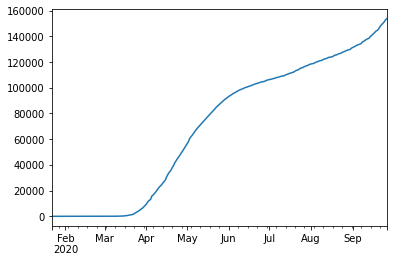

In [397]:
# Display confirmed cases of Canada (sample)
series = get_country_data("Canada", world_confirmed_grouped_df )
series.plot()
pyplot.show()

## Arima modeling

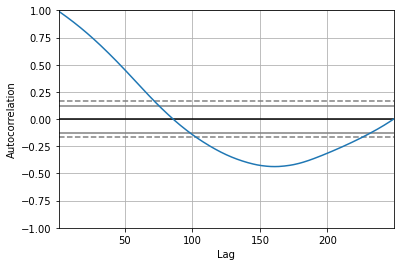

In [398]:
# Autocorrelation test
autocorrelation_plot(series)
pyplot.show()

Positive correlation in the first 80 to 90 lags, let's choose 10 for the AR parameter. Higher number makes ARIMA calcualtion longer

In [399]:
# Calculate arima for Canada 
model = ARIMA(series.values,order=(10,1,0), dates=series.index, freq='D')
model_fit = model.fit(disp=0)

In [400]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  248
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1714.179
Method:                       css-mle   S.D. of innovations            241.291
Date:                Sun, 27 Sep 2020   AIC                           3452.359
Time:                        13:29:06   BIC                           3494.520
Sample:                    01-23-2020   HQIC                          3469.331
                         - 09-26-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        645.5309    286.562      2.253      0.024      83.880    1207.182
ar.L1.D.y      0.0421      0.063      0.673      0.501      -0.080       0.165
ar.L2.D.y      0.1919      0.061      3.150      0.0

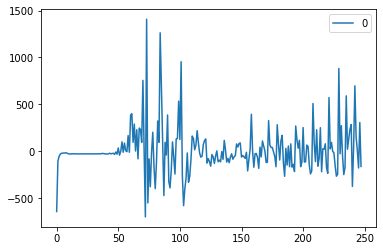

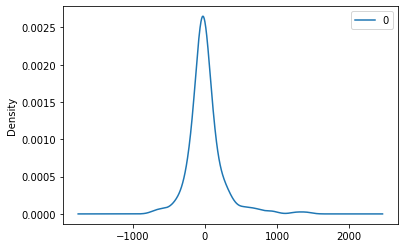

               0
count  248.00000
mean     6.73853
std    244.64765
min   -702.94781
25%    -91.04383
50%    -29.05004
75%     76.92515
max   1406.85008


In [401]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

#### Split train, test and predict, evaluate prediction

In [402]:
def calculate_mse(series,train_size=65, arima_order=(10,1,0)):
    """Given a series, calculate the mse given the arima_order"""
    # Split train, test and predict
    X = series.values
    # Split train/test in rouhgly 65%/35%
    up_to = int(len(X) * 0.65)
    train, test = X[0:up_to], X[up_to:len(X)]
    # initial historical (train) data
    history = [x for x in train]
    # To keep track of predictions
    predictions = []
    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=(10,1,0))
        model_fit = model.fit(disp=0)	
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        actual = test[t] 
        # Append real value to history 
        history.append(actual)
        # Uncomment if print desired 
        #print(f'Prediction={yhat}, Expected={actual}')
    # Calculate MSE    
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()


Test MSE: 56832.792


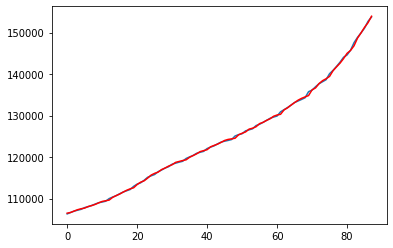

In [403]:
# Calculate MSE for Canada (series)
calculate_mse(series)

In [426]:
# Calculate ARIMA for Canada and display forexast for about 30 days
def plot_country_forecast(country_name, df=world_confirmed_grouped_df):
    """Given a country, forecast 30 days ahead from 09/26"""
    series = get_country_data(country_name, df) 
    model = ARIMA(series.values,order=(10,1,0), dates=series.index, freq='D')
    fig2, ax = plt.subplots(figsize=(12,8))
    ax = series.loc['2020-01-22':].plot(ax=ax, label="Confirmed")
    model_fit = model.fit(disp=0)
    model_fit.plot_predict('2020-09-26','2020-10-26', dynamic=True, ax=ax, plot_insample=False)
    plt.show()

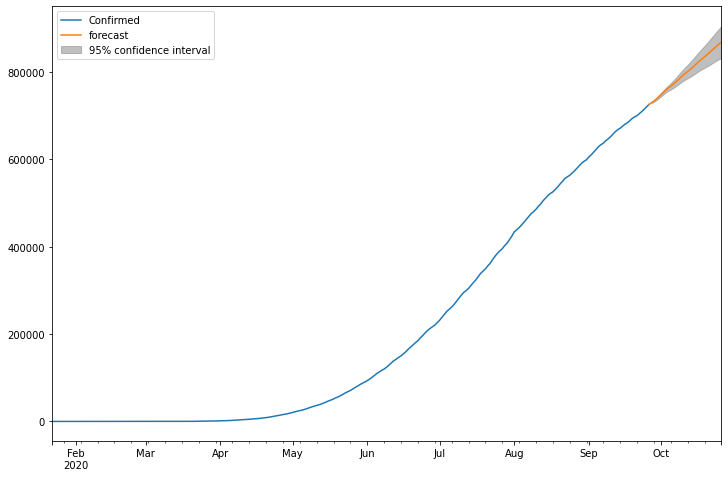

In [427]:
# Forecast
plot_country_forecast("Mexico")

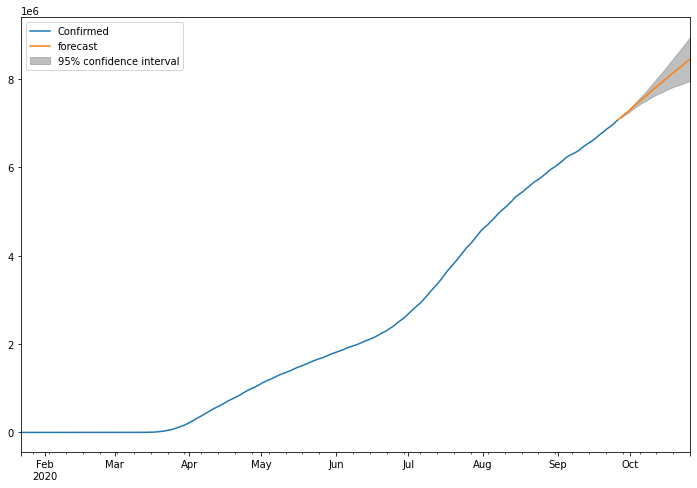

In [428]:
# Forecast US
plot_country_forecast("US")

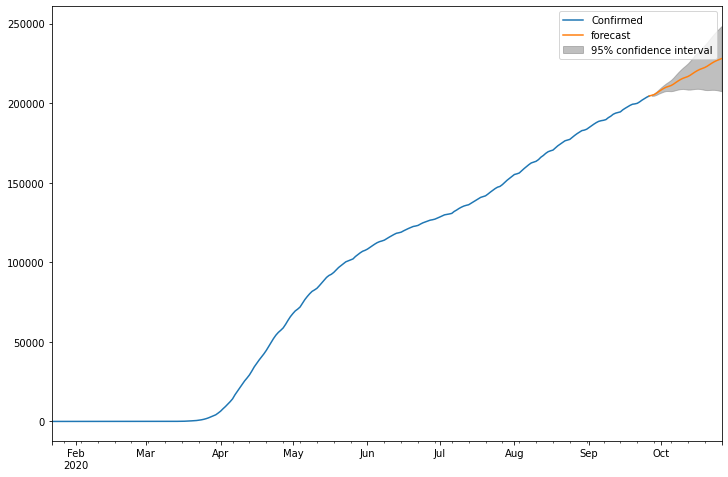

In [430]:
# Forecast US death
plot_country_forecast("US",df=world_death_grouped_df)

### Conclusion

Based on confirmed and death forecasts, the US trajectory is going to continue to grow rapidly outward. It appears that by end of Oct, there will be sadly aboug 225,000 deaths.